# Classification of Bat Hunting Calls

offene Frage:
- Sprache (deutsch/englisch)
- Vorverarbeitung wav -> spec

## Project by Johannes Maaß and Maja Gentsch


#### (Machine Learning Course, Prof. Vogel)

In [80]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Raw Data - EDA

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = 'batcallsv14.db'

with sqlite3.connect(db_path) as db_con:
    cursor = db_con.cursor()

    n = cursor.execute("select count(*) from batcalls;")
    print(f"Anzahl Einträge: {n.fetchone()[0]}")

    head_df = pd.read_sql("select * from batcalls limit 10;", db_con)
head_df

Anzahl Einträge: 51719


,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
1,46731,0,1,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
2,49137,0,2,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
3,49557,0,3,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
4,22197,0,4,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
5,11958,0,5,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
6,15446,0,6,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
7,44262,0,7,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
8,46273,0,8,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
9,34856,0,9,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba


In [9]:
with sqlite3.connect(db_path) as db_con:

    bat_names = pd.read_sql("select bat, count(*) as number from batcalls group by bat;", db_con)
    bat_names.transpose()

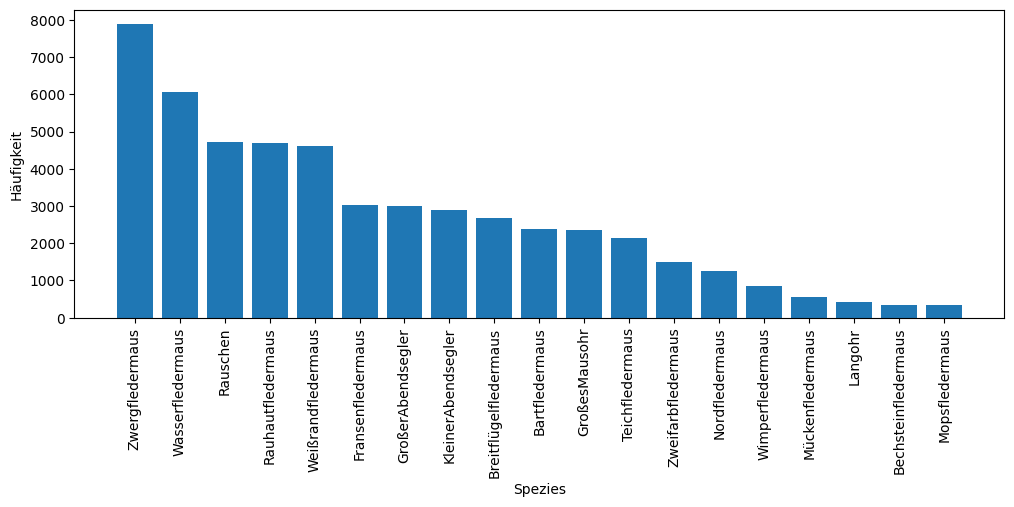

In [10]:
%matplotlib inline
sorted_bats = bat_names.sort_values(by='number', ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
plt.bar(sorted_bats['bat'],sorted_bats['number'])
plt.xticks(rotation=90)
plt.ylabel("Häufigkeit")
plt.xlabel("Spezies")
plt.show()

Wir haben einen Datensatz mit 51719 Einträgen mit folgenden Attributen:
- call: wahrscheinlich Nummerierung der Aufnahmen
- target: numerische Codierung der Klasse
- id: Tabellen-spezifische ID
- bat: nominaler Wert von Target (Bezeichnung der Fledermaus)
- arr: Aufnahmen der Jagdrufe
- db: ?

Insgesamt sind 18 verschiedene Fledermausarten und Rauschen aufgenommen worden. Die Arten sind eher ungleich verteilt.

Wir werden im Folgenden die sechs am häufigsten vorkommenden Fledermäuse und das Rauschen verwenden, um verschiedene Modelle auszuprobieren.

In [11]:
our_bats = bat_names.sort_values(by='number', ascending=False).head(7)
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


In [12]:
targets = list(our_bats.index)

In [13]:
targets

[18, 14, 12, 11, 15, 3, 4]

## Data Collection and Preprocessing

In [14]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import sqlite3
import os
from scipy.signal import butter, lfilter

In [15]:
def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)
    
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())
    
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def make_sets(data_rows, targets):
  spec_list = []
  label_list = []
  for row in data_rows:
    #target_class = targets.index(row[1])
    target_class = row[1]
    call = row[4].astype(np.float32, order='C') / 32768.0

    # Bandpass to filter low and high frequencies
    data_bp = butter_bandpass_filter(call, 1500, 12000, 44100, 5)

    # Normalize
    data_bp -= np.mean(data_bp)
    data_bp /= np.std(data_bp)

    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(data_bp, n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)

    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]

    spec_list.append(stft)
    label_list.append(target_class)
  return spec_list, label_list

In [16]:
def load_spectrograms(data_path, num_per_class, targets) -> list:

    num_calls = num_per_class
    all_rows = []

    sqlite3.register_adapter(np.ndarray, _adapt_array)
    sqlite3.register_converter("ARRAY", _convert_array)
    
    with sqlite3.connect(db_path, detect_types=True) as con:
      cur = con.cursor()
      for target in targets:
        if num_calls > 0:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target} LIMIT {num_calls}")]
        else:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target}")]
        all_rows.extend(rows)

    spectrograms, labels = make_sets(all_rows, targets)
    return spectrograms, labels

In [74]:
X, y = load_spectrograms(data_path="./data", num_per_class=100, targets=targets)
print(len(X))

/tmp/ipykernel_52623/2704522252.py:41: RuntimeWarning:

divide by zero encountered in log10



700


In [75]:
frequency = {cl : 0 for cl in y}
for cl in y:
    frequency[cl]+=1
frequency

{18: 100, 14: 100, 12: 100, 11: 100, 15: 100, 3: 100, 4: 100}

In [76]:
X[0].shape

(256, 128, 1)

In [77]:
for i in range(len(X)):
    X[i] = X[i].reshape(256,128)

In [78]:
X[3].shape

(256, 128)

### 1.1 PCA

#### n_components = 2 (nur zur Veranschaulichung)

Da die PCA einen Vektor und keine Matrix als Input erwartet, müssen wir die einzelnen "Zeilen" des Spektrogramms aneinander hängen, dazu nutzen wir die numpy Funktion nd_array.flatten():

In [81]:
flat_X = np.array([spec.flatten() for spec in X])
flat_X = StandardScaler().fit_transform(flat_X)
flat_X.shape

(700, 32768)

In [82]:
only_bat_flat_X = []
only_bat_y = []
is_bat = [cl != 12 for cl in y]
for i in range(len(flat_X)):
    if(is_bat[i]):
        only_bat_flat_X.append(flat_X[i])
        only_bat_y.append(y[i])
np.array(only_bat_flat_X).shape

(600, 32768)

Zur Veranschaulichung wenden wir auf alle Daten eine PCA an, die die Fetaure-Vektoren auf 2 Hauptkomponenten reduziert:

In [83]:
from sklearn.decomposition import PCA
#PCA auf alle unsere Fledermaus-Instanzen
only_bat_reduced_X = PCA(n_components=2).fit_transform(only_bat_flat_X)
#PCA auf Fledermaus-Instanzen und Rauschen
reduced_X = PCA(n_components=2).fit_transform(flat_X)
reduced_X.shape

(700, 2)

In [84]:
#Dataframes für Ergebnisse beider PCAs erstellen (inkl. der zugehörigen Klasse)
reduced_data = pd.DataFrame(data = reduced_X, columns=["x1","x2"])
reduced_data.insert(2, "y", y)

only_bat_reduced_data = pd.DataFrame(data = only_bat_reduced_X, columns=["x1","x2"])
only_bat_reduced_data.insert(2, "y", only_bat_y)

In [85]:
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


Text(0, 0.5, 'x2')

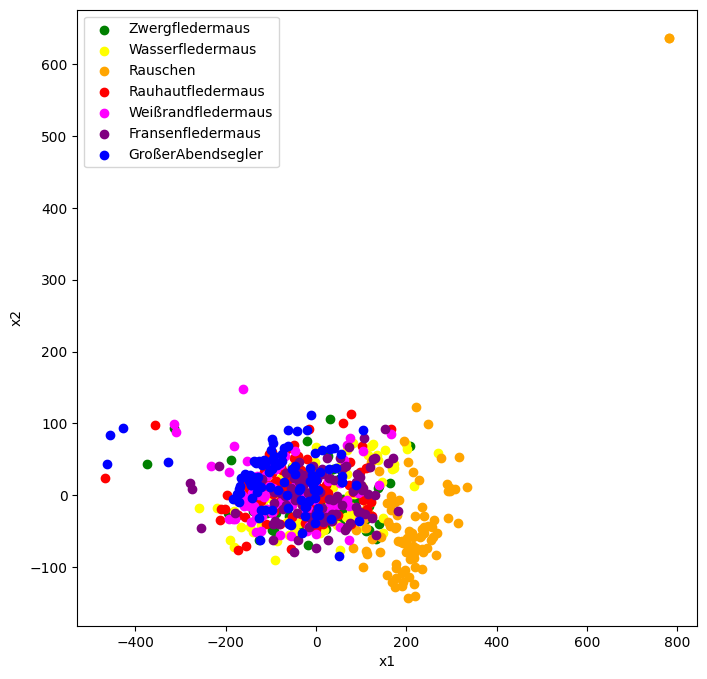

In [86]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(reduced_data[reduced_data['y'] == 18]['x1'], 
            reduced_data[reduced_data['y'] == 18]['x2'],
            color="green", label="Zwergfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 14]['x1'], 
            reduced_data[reduced_data['y'] == 14]['x2'],
            color="yellow", label="Wasserfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 12]['x1'], 
            reduced_data[reduced_data['y'] == 12]['x2'],
            color="orange", label="Rauschen")
plt.scatter(reduced_data[reduced_data['y'] == 11]['x1'], 
            reduced_data[reduced_data['y'] == 11]['x2'],
            color="red", label="Rauhautfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 15]['x1'], 
            reduced_data[reduced_data['y'] == 15]['x2'],
            color="magenta", label="Weißrandfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 3]['x1'], 
            reduced_data[reduced_data['y'] == 3]['x2'],
            color="purple", label="Fransenfledermaus")
plt.scatter(reduced_data[reduced_data['y'] == 4]['x1'], 
            reduced_data[reduced_data['y'] == 4]['x2'],
            color="blue", label="GroßerAbendsegler")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")

In dieser Grafik sind die beiden Hauptkomonenten x1 und x2 der Spektrogramme der Fledermaus-Arten und des Rauschens dargestellt.
Dabei kann man erkennen, dass die verschiedenen Fledermaus-Spezies in diesen Eigenschaften sehr ähnlich sind, während als "Rauschen" beschriebene Aufnahmen (alles außer Fledermäuse) sich etwas vom Rest der Daten abheben.

In nachfolgender Grafik ist das Ergebnis der PCA ohne Rauschen dargestellt. Hier lässt sich zumindest ansatzweise eine Differnzierung des Großen Abendseglers von den anderen Klassen erkennen.

Text(0, 0.5, 'x2')

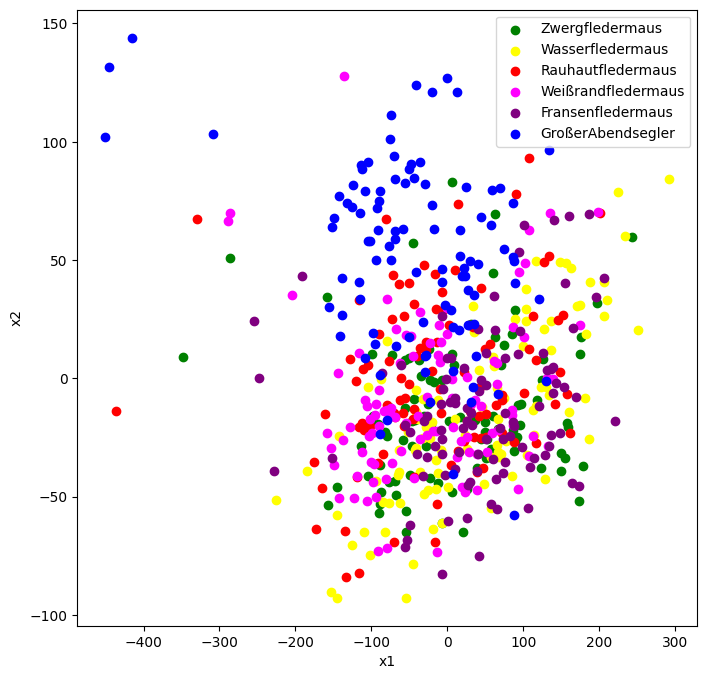

In [87]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 18]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 18]['x2'],
            color="green", label="Zwergfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 14]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 14]['x2'],
            color="yellow", label="Wasserfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 11]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 11]['x2'],
            color="red", label="Rauhautfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 15]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 15]['x2'],
            color="magenta", label="Weißrandfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 3]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 3]['x2'],
            color="purple", label="Fransenfledermaus")
plt.scatter(only_bat_reduced_data[only_bat_reduced_data['y'] == 4]['x1'], 
            only_bat_reduced_data[only_bat_reduced_data['y'] == 4]['x2'],
            color="blue", label="GroßerAbendsegler")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")

#### n_components = 3 (nur zur Veranschaulichung)

In [88]:
only_bat_reduced_X_3D = PCA(n_components=3).fit_transform(only_bat_flat_X)
reduced_X_3D = PCA(n_components=3).fit_transform(flat_X)

labels = {18: "Zwergfledermaus", 14: "Wasserfledermaus", 12: "Rauschen", 
          11: "Rauhautfledermaus", 15: "Weißrandfledermaus", 3: "Fransenfledermaus", 
          4: "GroßerAbendsegler"}
y_labels = [labels[cl] for cl in y]
only_bat_y_labels = [labels[cl] for cl in only_bat_y]

#Dataframes für Ergebnisse beider PCAs erstellen (inkl. der zugehörigen Klasse)
reduced_data_3D = pd.DataFrame(data = reduced_X_3D, columns=["x","y","z"])
reduced_data_3D.insert(3, "bat", y_labels)
 
only_bat_reduced_data_3D = pd.DataFrame(data = only_bat_reduced_X_3D, columns=["x","y","z"])
only_bat_reduced_data_3D.insert(3, "bat", only_bat_y_labels)

##### Plot der PCA inklusive Rauschen

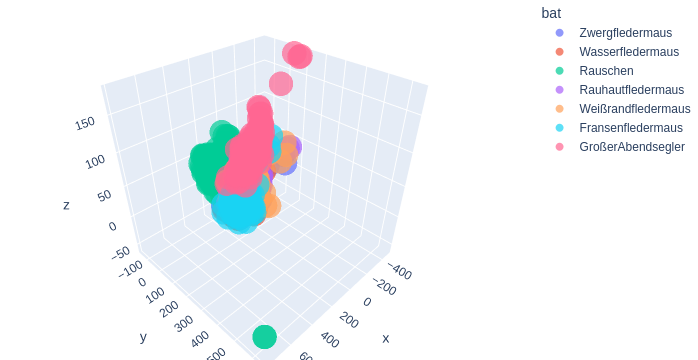

In [89]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(reduced_data_3D, x='x', y='y', z='z', color='bat', 
                    opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

##### Plot der PCA exklusive Rauschen

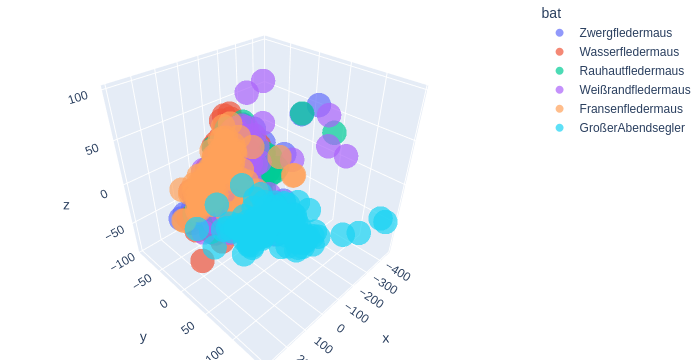

In [90]:
df = px.data.iris()
fig = px.scatter_3d(only_bat_reduced_data_3D, x='x', y='y', z='z', color='bat', 
                    opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Bei der Reduzierung durch PCA auf 3 Dimensionen ist schon eine bessere Abgrenzung zu erkennen. Leider haben wir bisher keine bessere Darstellungsmöglichkeit der 3D-Daten gefunden.
Im Folgenden wollenw ir für verschiedene n_components den K-Nearest-Neighbour ausprobieren.

### 1.2 KNN

In [72]:
X = pd.DataFrame(flat_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 1.3 Decision Tree

### 2. Neural Net